# Classification - Determine International Rating 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import math
import re
warnings.filterwarnings('ignore')
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix, roc_curve, auc, roc_auc_score
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import MultiLabelBinarizer, LabelBinarizer
from sklearn.multiclass import OneVsRestClassifier, _fit_binary
from itertools import cycle, product
from sklearn.manifold import TSNE, MDS, Isomap
import seaborn as sns
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import hyperopt.pyll.stochastic
import time
#from sklearn.externals.joblib import Parallel, delayed
from sklearn.ensemble import VotingClassifier
from joblib import Parallel, delayed

In [3]:
# Step 1. Prepare data

X:  (3563, 56)
1.0    3236
2.0     262
3.0      53
4.0      12
Name: International Reputation, dtype: int64
n_classes:  4


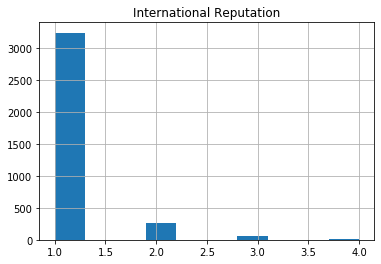

In [4]:
from sklearn.preprocessing import label_binarize

# Read original data
sample_data = pd.read_csv('fifa19_ready_data.csv', encoding='utf-8')
# Remove ID
sample_data = sample_data.drop('ID', axis=1)
# Separate internation rating result with rest
y = sample_data['International Reputation']
X = sample_data.drop('International Reputation', axis=1)
print('X: ', X.shape)

# Binarize the rating result
# Rating score 5 records is only 6 / 18208, so it cannot be predicated with too little data,
# we convert the score 5 to 4, so only choose rating scores 1, 2, 3, 4 to classify.
sample_data['International Reputation'].loc[sample_data['International Reputation'] == 5] = 4
sample_data.hist(column='International Reputation')
print(sample_data['International Reputation'].value_counts())

y = label_binarize(y, classes=[1, 2, 3, 4])
n_classes = y.shape[1]
print('n_classes: ', n_classes)

X_train:  (2375, 56) X_test:  (1188, 56)
Rating Score value counts:  1
1    2162
0     213
dtype: int64


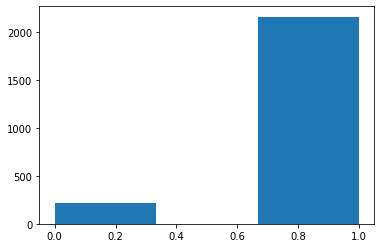

 
Rating Score value counts:  2
0    2203
1     172
dtype: int64


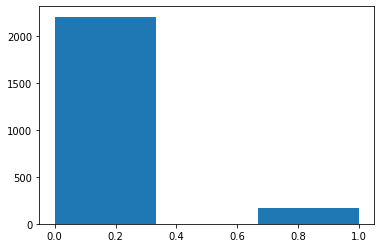

 
Rating Score value counts:  3
0    2343
1      32
dtype: int64


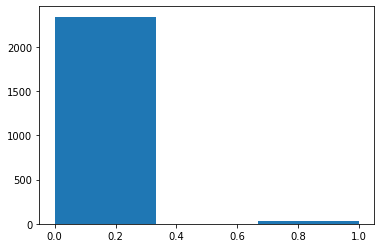

 
Rating Score value counts:  4
0    2366
1       9
dtype: int64


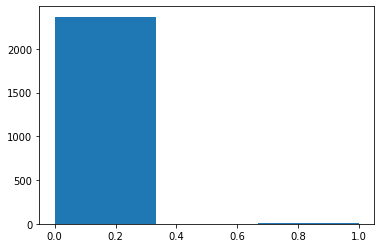

In [6]:
# Divide data into training set and testing set
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=1/3,random_state=1)
print('X_train: ', X_train.shape, 'X_test: ', X_test.shape)

#print(y_train)
for i in range(n_classes):
    print("Rating Score value counts: ", i + 1)
    print(pd.value_counts(y_train[:, i]))
    plt.hist(y_train[:, i], bins=3)
    plt.show()
    print(" ")


In [7]:
# Standardize records
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  
scaler.fit(X_train)

X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test) 
print('X_train: ', X_train.shape, 'X_test: ', X_test.shape)

X_train:  (2375, 56) X_test:  (1188, 56)


In [6]:
# Step 2. Solve with Logistic Regression

In [7]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, make_scorer
from scipy import interp
from itertools import cycle

# Create function to store ROC computation results for all classification classes
def compute_roc_auc_in_classes(test_data, test_result, num_classes=n_classes):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    roc_result = {'fpr': fpr, 'tpr': tpr, 'roc_auc': roc_auc }
    
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(test_data[:, i], test_result[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(test_data.ravel(), test_result.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    # Compute macro-average ROC curve and ROC area
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    return roc_result

# Draw ROC plot based on ROC computation result
def draw_roc_auc_in_classes(roc_auc_result, learn_method, num_classes=n_classes):
    fpr = roc_auc_result['fpr']
    tpr = roc_auc_result['tpr']
    roc_auc = roc_auc_result['roc_auc']
    
    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["macro"], tpr["macro"],
             label='Average ROC (area = {0:0.4f})'.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])
    for i, color in zip(range(num_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=1,
                 label='ROC of rating {0} (area = {1:0.4f})'.format((i + 1), roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for {}'.format(learn_method))
    plt.legend(loc="lower right")
    plt.show()
    

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

# create logistic regression model for multi-class and one vs rest mode
logreg = OneVsRestClassifier(LogisticRegression(solver='sag', multi_class='ovr', random_state=1))
#print("parameters: ", logreg.get_params().keys())

# Create GridSearch to find best model
penalty_param = ['l2']
solver_param = ['sag', 'saga']
C_param = [0.0001, 0.001, 0.01, 1, 50, 100, 200, 1000]
hyperparameters = dict(estimator__C=C_param, estimator__penalty=penalty_param, estimator__solver=solver_param)

# Fit model using gridsearch
score_making_func = make_scorer(roc_auc_score, average='macro')
grid_logreg = GridSearchCV(logreg, hyperparameters, scoring = score_making_func, verbose=0)

# Best model
best_logreg = grid_logreg.fit(X_train, y_train)

#Print all the Parameters that gave the best results:
print('Best Parameters',grid_logreg.best_params_)


Best Parameters {'estimator__C': 100, 'estimator__penalty': 'l2', 'estimator__solver': 'sag'}


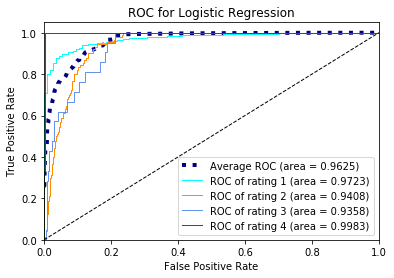

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

# Compute test scores
y_score = best_logreg.fit(X_train, y_train).decision_function(X_test)

# Compute ROC AUC score
logreg_result = compute_roc_auc_in_classes(y_test, y_score, num_classes=n_classes)

# Draw ROC plot
draw_roc_auc_in_classes(logreg_result, 'Logistic Regression', num_classes=n_classes)


In [10]:
# Assign Best score
roc_logreg = logreg_result['roc_auc']['macro']
print("Best ROC score for logistic regression: {0:0.4f}".format(roc_logreg))

Best ROC score for logistic regression: 0.9625


In [11]:
# Step 3. Solve with Naive Bayes

In [12]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
import time

def show_time_spent(start_time):
    time_used = time.time() - start_time
    return "{}:{}:{}".format(int(time_used / 3600), int(time_used % 3600 / 60), int(time_used % 60))

kernel = 1.0 * RBF(1.0)

# create Naive Bayes model for multi-class and one vs rest mode
gaussian_proc = OneVsRestClassifier(GaussianProcessClassifier(kernel=kernel, multi_class='one_vs_rest', random_state=1))
print('Created gaussian_proc')
#print("parameters: ", gaussian_proc.get_params().keys())
#print(sorted(metrics.SCORERS.keys()))

# Create GridSearch to find best model
max_iter_param = [10, 20, 30]
warm_state_param = [ False ]
hyperparameters = dict(estimator__max_iter_predict=max_iter_param, estimator__warm_start=warm_state_param)

# Fit model using gridsearch
score_making_func = make_scorer(roc_auc_score, average='macro')
grid_gaussian_proc = GridSearchCV(gaussian_proc, hyperparameters, scoring=score_making_func, verbose=0)

Created gaussian_proc


In [13]:
# Compute test scores
timer_check = time.time()
print('start training')

# Best model
best_gaussian_proc = grid_gaussian_proc.fit(X_train, y_train)

#Print all the Parameters that gave the best results:
print('Best Parameters', grid_gaussian_proc.best_params_)

print('training spent: ', show_time_spent(timer_check))

start training
Best Parameters {'estimator__max_iter_predict': 20, 'estimator__warm_start': False}
training spent:  0:20:21


In [14]:
#timer_check = time.time()
print('start testing')
y_pred_proba = best_gaussian_proc.predict_proba(X_test)
#print('testing spent: ', show_time_spent(timer_check))
print('y_pred_proba: ', y_pred_proba.shape)

start testing
y_pred_proba:  (1188, 4)


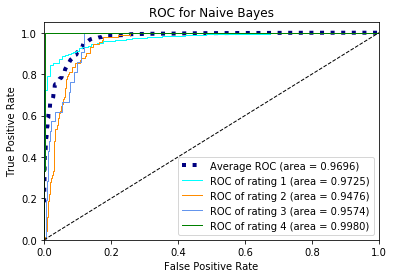

In [15]:
# Compute ROC AUC score
gaussion_proc_result = compute_roc_auc_in_classes(y_test, y_pred_proba, num_classes=n_classes)

# Draw ROC plot
draw_roc_auc_in_classes(gaussion_proc_result, 'Naive Bayes', num_classes=n_classes)

In [16]:
# Assign Best ROC value
roc_gaussian_proc = gaussion_proc_result['roc_auc']["macro"]
print('Best ROC score for Naive Bayes: {0:0.4f}'.format(roc_gaussian_proc))

Best ROC score for Naive Bayes: 0.9696


In [17]:
# Step 4. Solve with Decision Tree

In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

# create Decision Tree model for multi-class and one vs rest mode
decision_tree = OneVsRestClassifier(DecisionTreeClassifier(random_state=1))
print('Created decision_tree')
#print("parameters: ", decision_tree.get_params().keys())

# Create GridSearch to find best model
criterion_param = ['entropy', 'gini']
max_depth_param = [ 3, 4, 5, 6, 7, 8, 9, 10]
hyperparameters = dict(estimator__criterion=criterion_param, estimator__max_depth=max_depth_param)

# Fit model using gridsearch
score_making_func = make_scorer(roc_auc_score, average='macro') 
grid_decision_tree = GridSearchCV(decision_tree, hyperparameters, scoring = score_making_func, verbose=0)
#print(sorted(metrics.SCORERS.keys()))

Created decision_tree


In [19]:
# Best model
best_decision_tree = grid_decision_tree.fit(X_train, y_train)

#Print all the Parameters that gave the best results:
print('Best Parameters', grid_decision_tree.best_params_)

# Compute test scores
y_pred_proba = best_decision_tree.predict_proba(X_test)
print('y_pred_proba: ', y_pred_proba.shape)

Best Parameters {'estimator__criterion': 'entropy', 'estimator__max_depth': 6}
y_pred_proba:  (1188, 4)


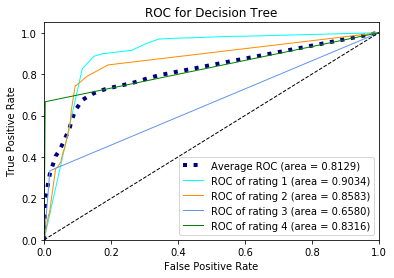

In [20]:
# Compute ROC AUC score
decision_tree_result = compute_roc_auc_in_classes(y_test, y_pred_proba, num_classes=n_classes)

# Draw ROC plot
draw_roc_auc_in_classes(decision_tree_result, 'Decision Tree', num_classes=n_classes)

In [21]:
# Assign Best ROC value
roc_decision_tree = decision_tree_result['roc_auc']["macro"]
print('Best ROC score for Decision Tree: {0:0.4f}'.format(roc_decision_tree))

Best ROC score for Decision Tree: 0.8129


Decision Tree for rating score  1


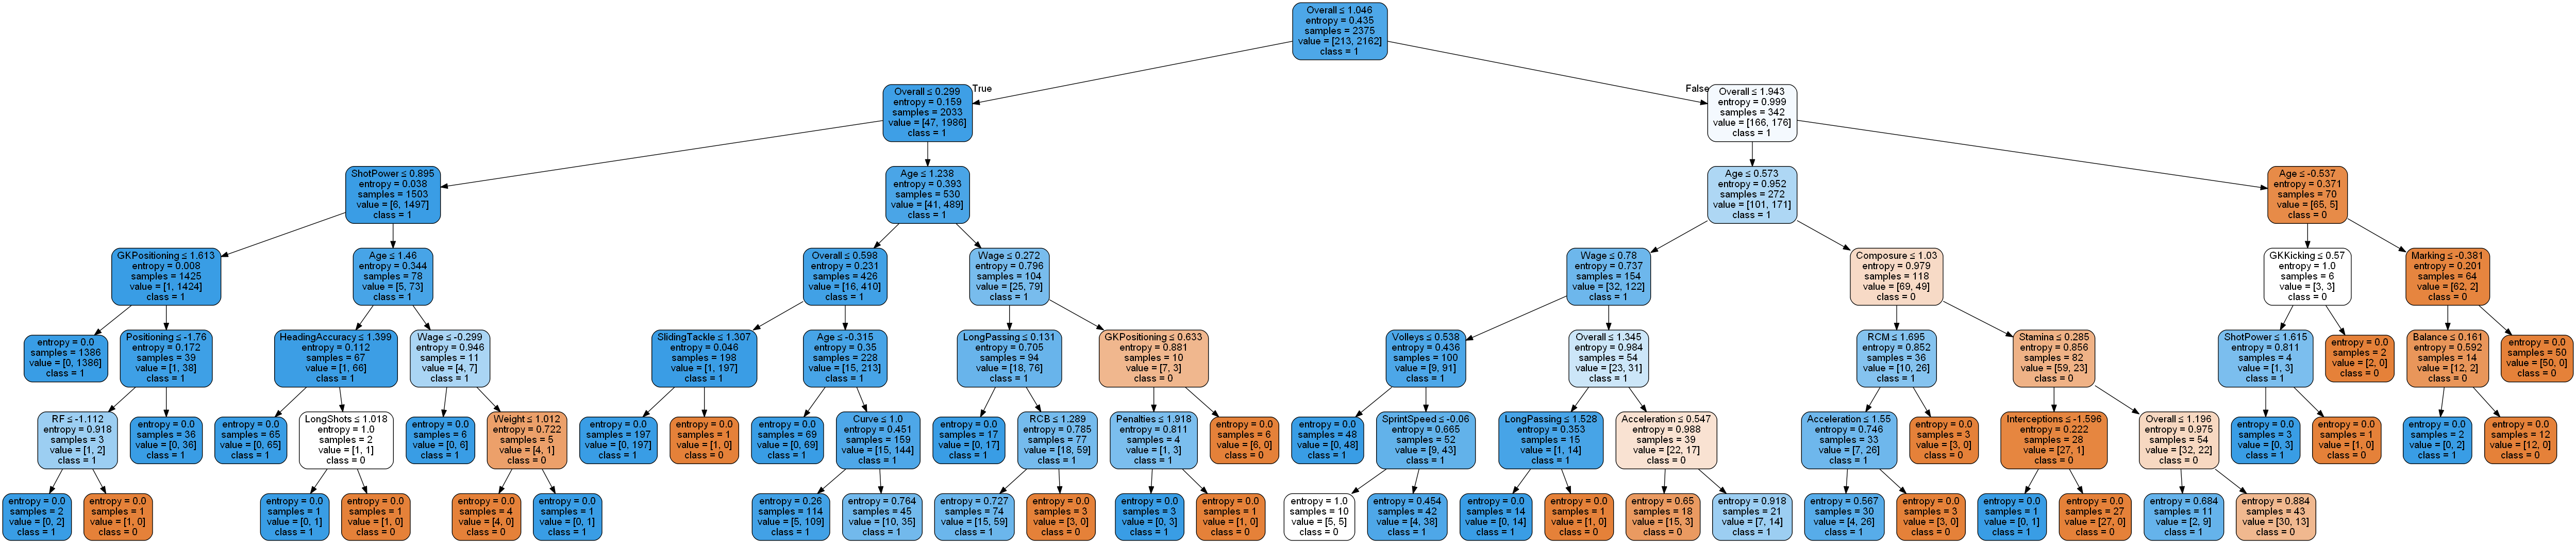

-----------
Decision Tree for rating score  2


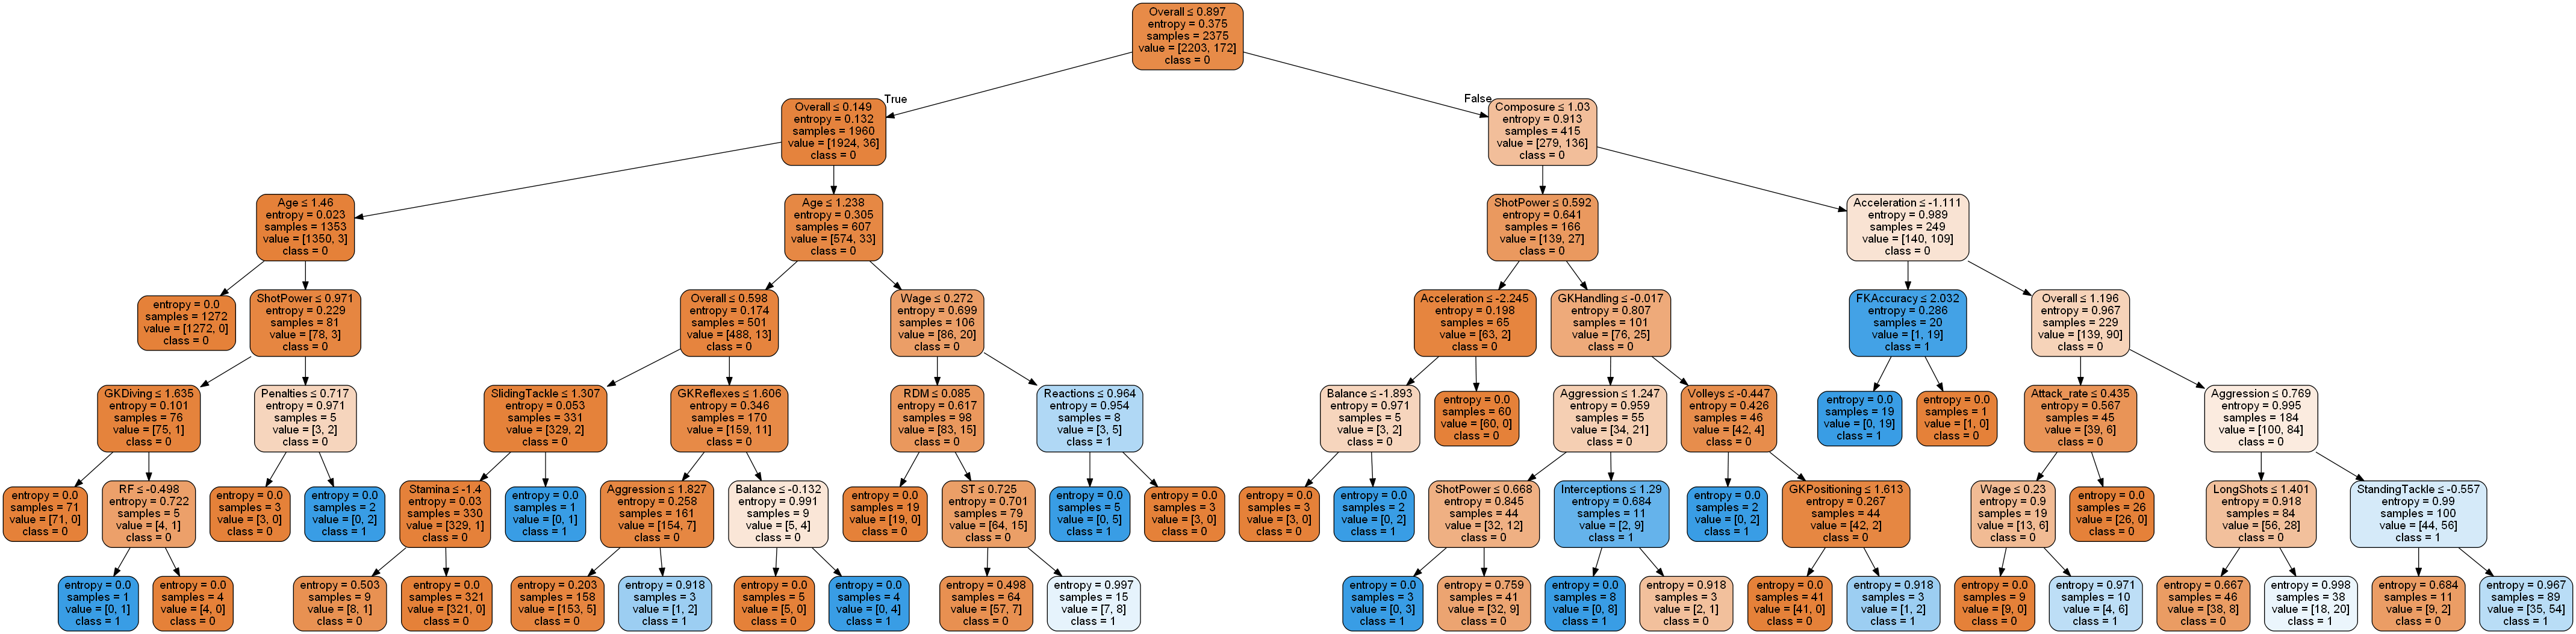

-----------
Decision Tree for rating score  3


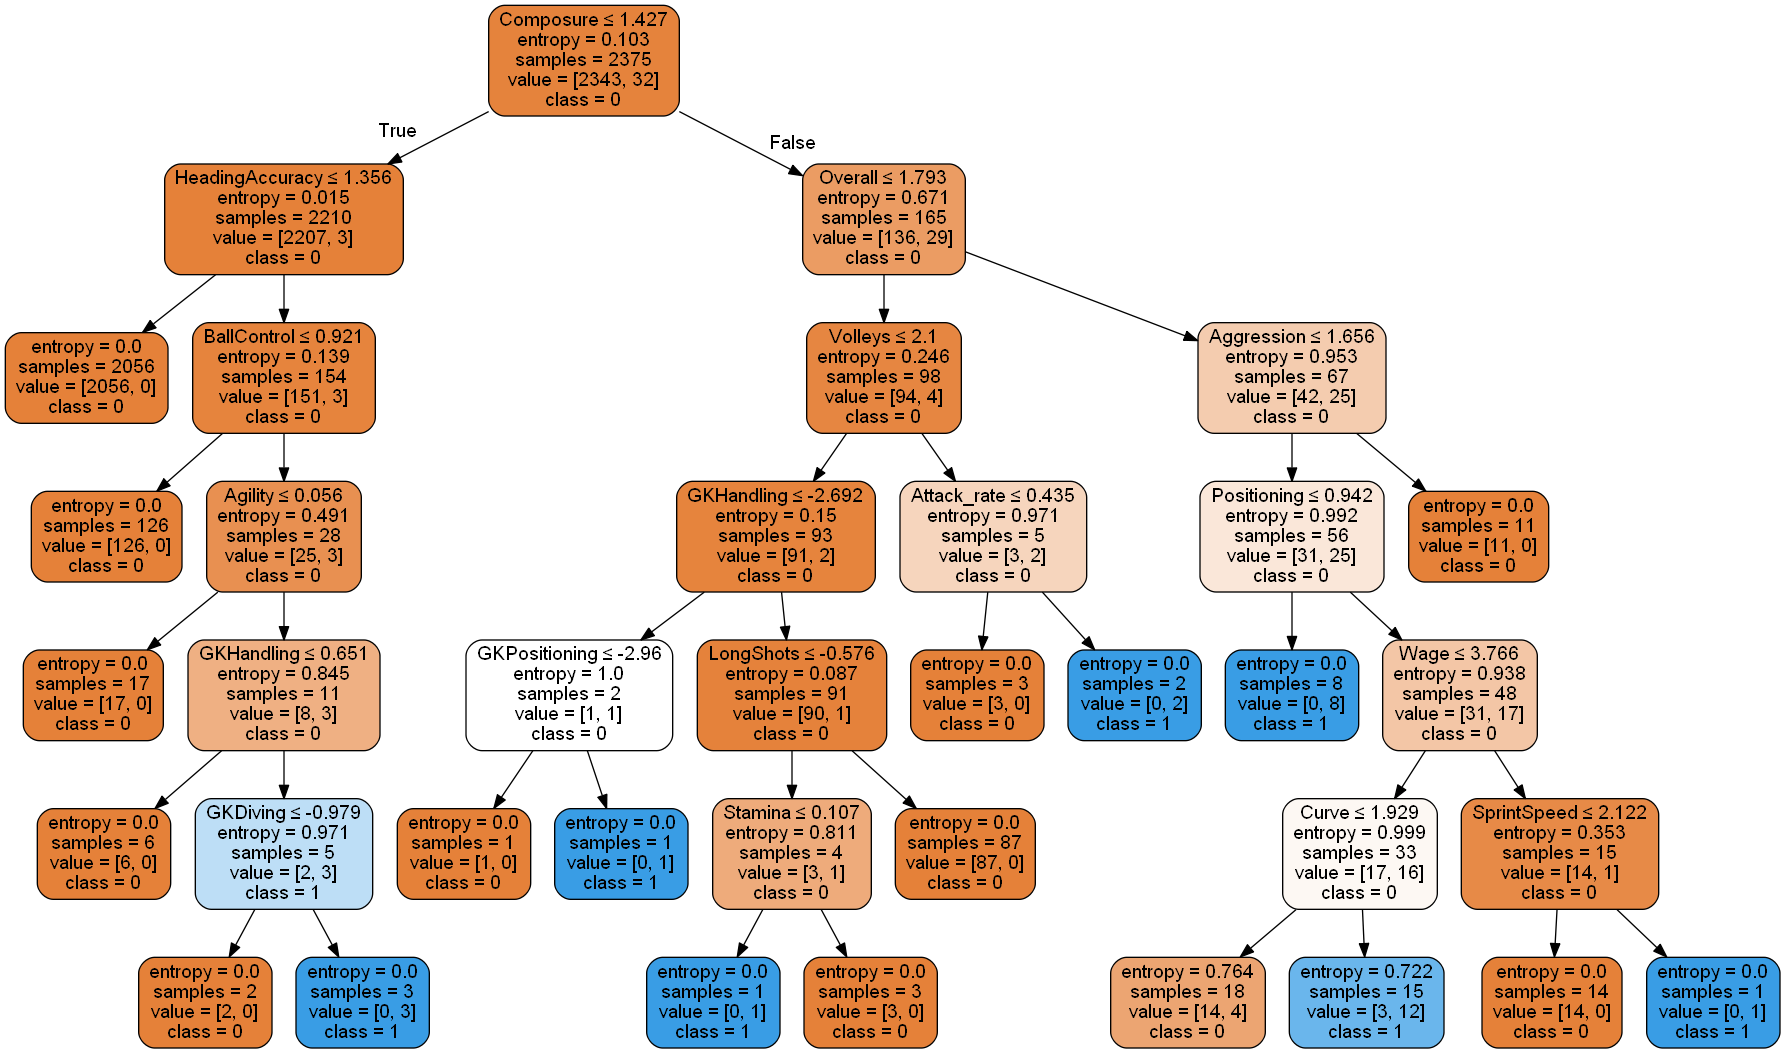

-----------
Decision Tree for rating score  4


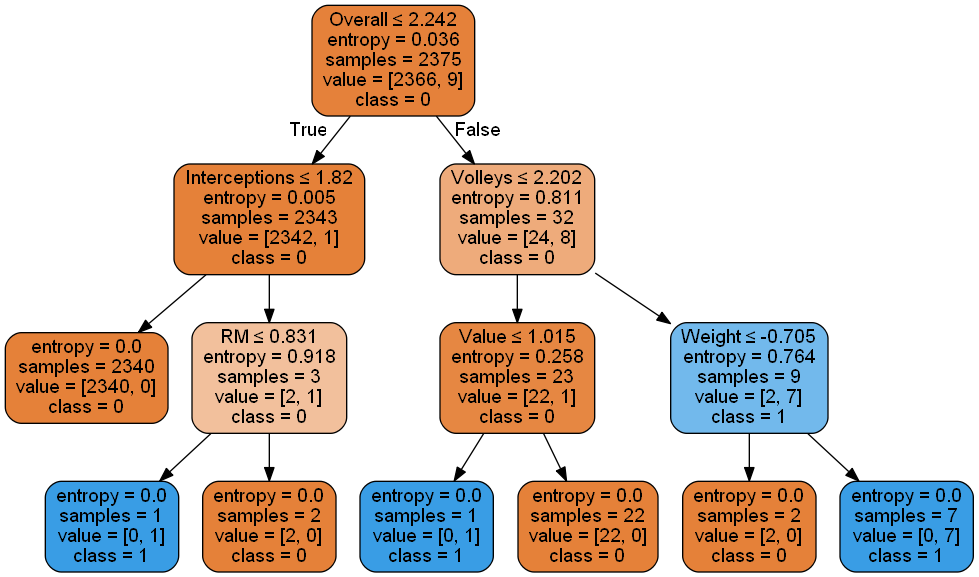

-----------


In [22]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

#DT visualizatin method 3
#!conda install -y pydotplus
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image, display
import pydotplus
import os
os.environ["PATH"] += os.pathsep + 'D:/App/Graphviz2.38/bin/'

def show_decision_tree(decision_tree_model, features, out_png_file='decision_tree.png', classes=['0', '1']):
    dot_data = StringIO()
    export_graphviz(decision_tree_model, out_file=dot_data,  
                    filled=True, rounded=True,
                    special_characters=True,feature_names=features, class_names=classes)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    graph.write_png(out_png_file)
    img = Image(filename = out_png_file)
    display(img)

for i in range(n_classes):
    rating_score = i + 1
    print('Decision Tree for rating score ', rating_score)
    out_png_file = 'decision_tree{}.png'.format(rating_score)
    show_decision_tree(best_decision_tree.best_estimator_.estimators_[i], X.columns, out_png_file=out_png_file)
    print("-----------")

In [23]:
# Step 5. Solve with SVM

In [24]:
from sklearn.svm import LinearSVC

# create model for multi-class and one vs rest mode
linear_svc = OneVsRestClassifier(LinearSVC(multi_class='ovr', random_state=1))
print('Created SVM')
#print("parameters: ", linear_svc.get_params().keys())

# Create GridSearch to find best model
max_iter_param = [50, 100, 500, 1000]
dul_param = [True, False]
C_param = [ 1, 4, 6, 10, 20 ]
fit_intercept_param  = [True, False]

hyperparameters = dict(estimator__C=C_param, estimator__dual=dul_param, 
                       estimator__fit_intercept=fit_intercept_param,
                       estimator__max_iter=max_iter_param)

# Fit model using gridsearch
score_making_func = make_scorer(roc_auc_score, average='macro')
grid_linear_svc = GridSearchCV(linear_svc, hyperparameters, scoring=score_making_func, verbose=0)

Created SVM


In [25]:
timer_check = time.time()
print('start training')

# Best model
best_linear_svc = grid_linear_svc.fit(X_train, y_train)

#Print all the Parameters that gave the best results:
print('Best Parameters', grid_linear_svc.best_params_)

print('training spent: ', show_time_spent(timer_check))

# Compute test scores
y_pred = best_linear_svc.predict(X_test)
print('y_pred: ', y_pred.shape)

start training
Best Parameters {'estimator__C': 6, 'estimator__dual': True, 'estimator__fit_intercept': False, 'estimator__max_iter': 100}
training spent:  0:0:44
y_pred:  (1188, 4)


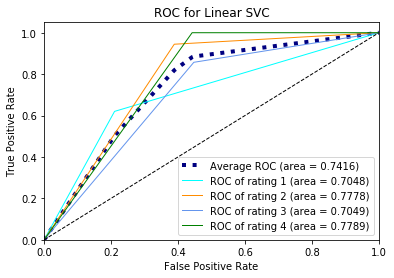

In [26]:
# Compute ROC AUC score
linear_svc_result = compute_roc_auc_in_classes(y_test, y_pred, num_classes=n_classes)

# Draw ROC plot
draw_roc_auc_in_classes(linear_svc_result, 'Linear SVC', num_classes=n_classes)

In [27]:
# Assign Best ROC value
roc_linear_svc = linear_svc_result['roc_auc']["macro"]
print('Best ROC score for Linear SVC: {0:0.4f}'.format(roc_linear_svc))

Best ROC score for Linear SVC: 0.7416


In [28]:
# Step 6. Solve with Neural Network

In [46]:
from sklearn.neural_network import MLPClassifier  

# create model for multi-class and one vs rest mode
mlp_nn = OneVsRestClassifier(MLPClassifier(early_stopping=True, random_state=1))
print('Created SVM')
#print("parameters: ", mlp_nn.get_params().keys())

# Create GridSearch to find best model
hidden_layer_sizes_param = [(3,),(5,),(10,),(3,3),(5,5),(10,10)]
max_iter_param = [10, 50, 100, 500, 1000]
activation_param = ['relu','tanh']
learning_rate_param = ['constant', 'invscaling', 'adaptive']
solver_param = ['lbfgs', 'sgd', 'adam']

hyperparameters = dict(estimator__hidden_layer_sizes=hidden_layer_sizes_param, 
                       estimator__max_iter=max_iter_param,
                       estimator__activation=activation_param,
                       estimator__learning_rate=learning_rate_param,
                       estimator__solver=solver_param)

# Fit model using gridsearch
score_making_func = make_scorer(roc_auc_score, average='macro')
grid_mlp_nn = GridSearchCV(mlp_nn, hyperparameters, scoring=score_making_func, verbose=0)

Created SVM


In [47]:
timer_check = time.time()
print('start training')

# Best model
best_mlp_nn = grid_mlp_nn.fit(X_train, y_train)

#Print all the Parameters that gave the best results:
print('Best Parameters', grid_mlp_nn.best_params_)

print('training spent: ', show_time_spent(timer_check))

# Compute test scores
y_pred_proba = best_mlp_nn.predict_proba(X_test)
print('y_pred_proba: ', y_pred_proba.shape)

start training
Best Parameters {'estimator__activation': 'tanh', 'estimator__hidden_layer_sizes': (3,), 'estimator__learning_rate': 'constant', 'estimator__max_iter': 50, 'estimator__solver': 'adam'}
training spent:  0:5:31
y_pred_proba:  (1188, 4)


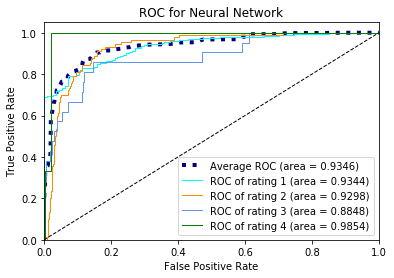

In [48]:
# Compute ROC AUC score
mlp_nn_result = compute_roc_auc_in_classes(y_test, y_pred_proba, num_classes=n_classes)

# Draw ROC plot
draw_roc_auc_in_classes(mlp_nn_result, 'Neural Network', num_classes=n_classes)

In [49]:
# Assign Best ROC value
roc_mlp_nn = mlp_nn_result['roc_auc']["macro"]
print('Best ROC score for Neural Network: {0:0.4f}'.format(roc_mlp_nn))

Best ROC score for Neural Network: 0.9346


In [50]:
# Step 7. Choose Best model

In [51]:
# Store best results for different model
avail_models = [
    {'name': 'Logistic Regression', 'roc_auc': roc_logreg},
    {'name': 'Naive Bayes', 'roc_auc': roc_gaussian_proc},
    {'name': 'Decision Tree', 'roc_auc': roc_decision_tree},
    {'name': 'Linear SVC', 'roc_auc': roc_linear_svc},
    {'name': 'Neural Network', 'roc_auc': roc_mlp_nn}
]

# Sort based on ROC area values
avail_models.sort(key=lambda sortKey : sortKey['roc_auc'], reverse=True)
print([(model['name'], model['roc_auc']) for model in avail_models])

[('Naive Bayes', 0.9696011481510143), ('Logistic Regression', 0.9625082520105874), ('Neural Network', 0.934636721708209), ('Decision Tree', 0.8128511032519392), ('Linear SVC', 0.7415986205896605)]


In [52]:
# We will compare and choose the best model to estimate the results,
# so Naive Bayes are selected
best_model_name, best_roc_auc = (avail_models[0]['name'], avail_models[0]['roc_auc'])
print('best_model_name: {0}, best_roc_auc: {1:0.4f}'.format(best_model_name, best_roc_auc))

best_model_name: Naive Bayes, best_roc_auc: 0.9696


100%|██████████| 1000/1000 [1:07:14<00:00,  2.28s/it, best loss: 0.07663125141001237]
                                                                         
activation              relu        relu        relu       relu      relu
alpha                21.6348     26.3578     20.1152    20.3418   29.5797
hidden_layer_sizes        38          43          43         43        35
learning_rate       adaptive    adaptive  invscaling   adaptive  constant
learning_rate_init  0.161469  0.00237053    0.141363   0.569107  0.144982
power_t             0.399918    0.447095   0.0990195  0.0103618  0.394216
solver                 lbfgs       lbfgs       lbfgs      lbfgs     lbfgs
best_score          0.923369    0.922106    0.921686   0.921686  0.921685
                                                                 
Hidden Layers    (29, 26)   (1, 45)    (8, 9)   (1, 52)   (5, 47)
Mean Test Score  0.925474  0.924632  0.924211  0.924211  0.923789


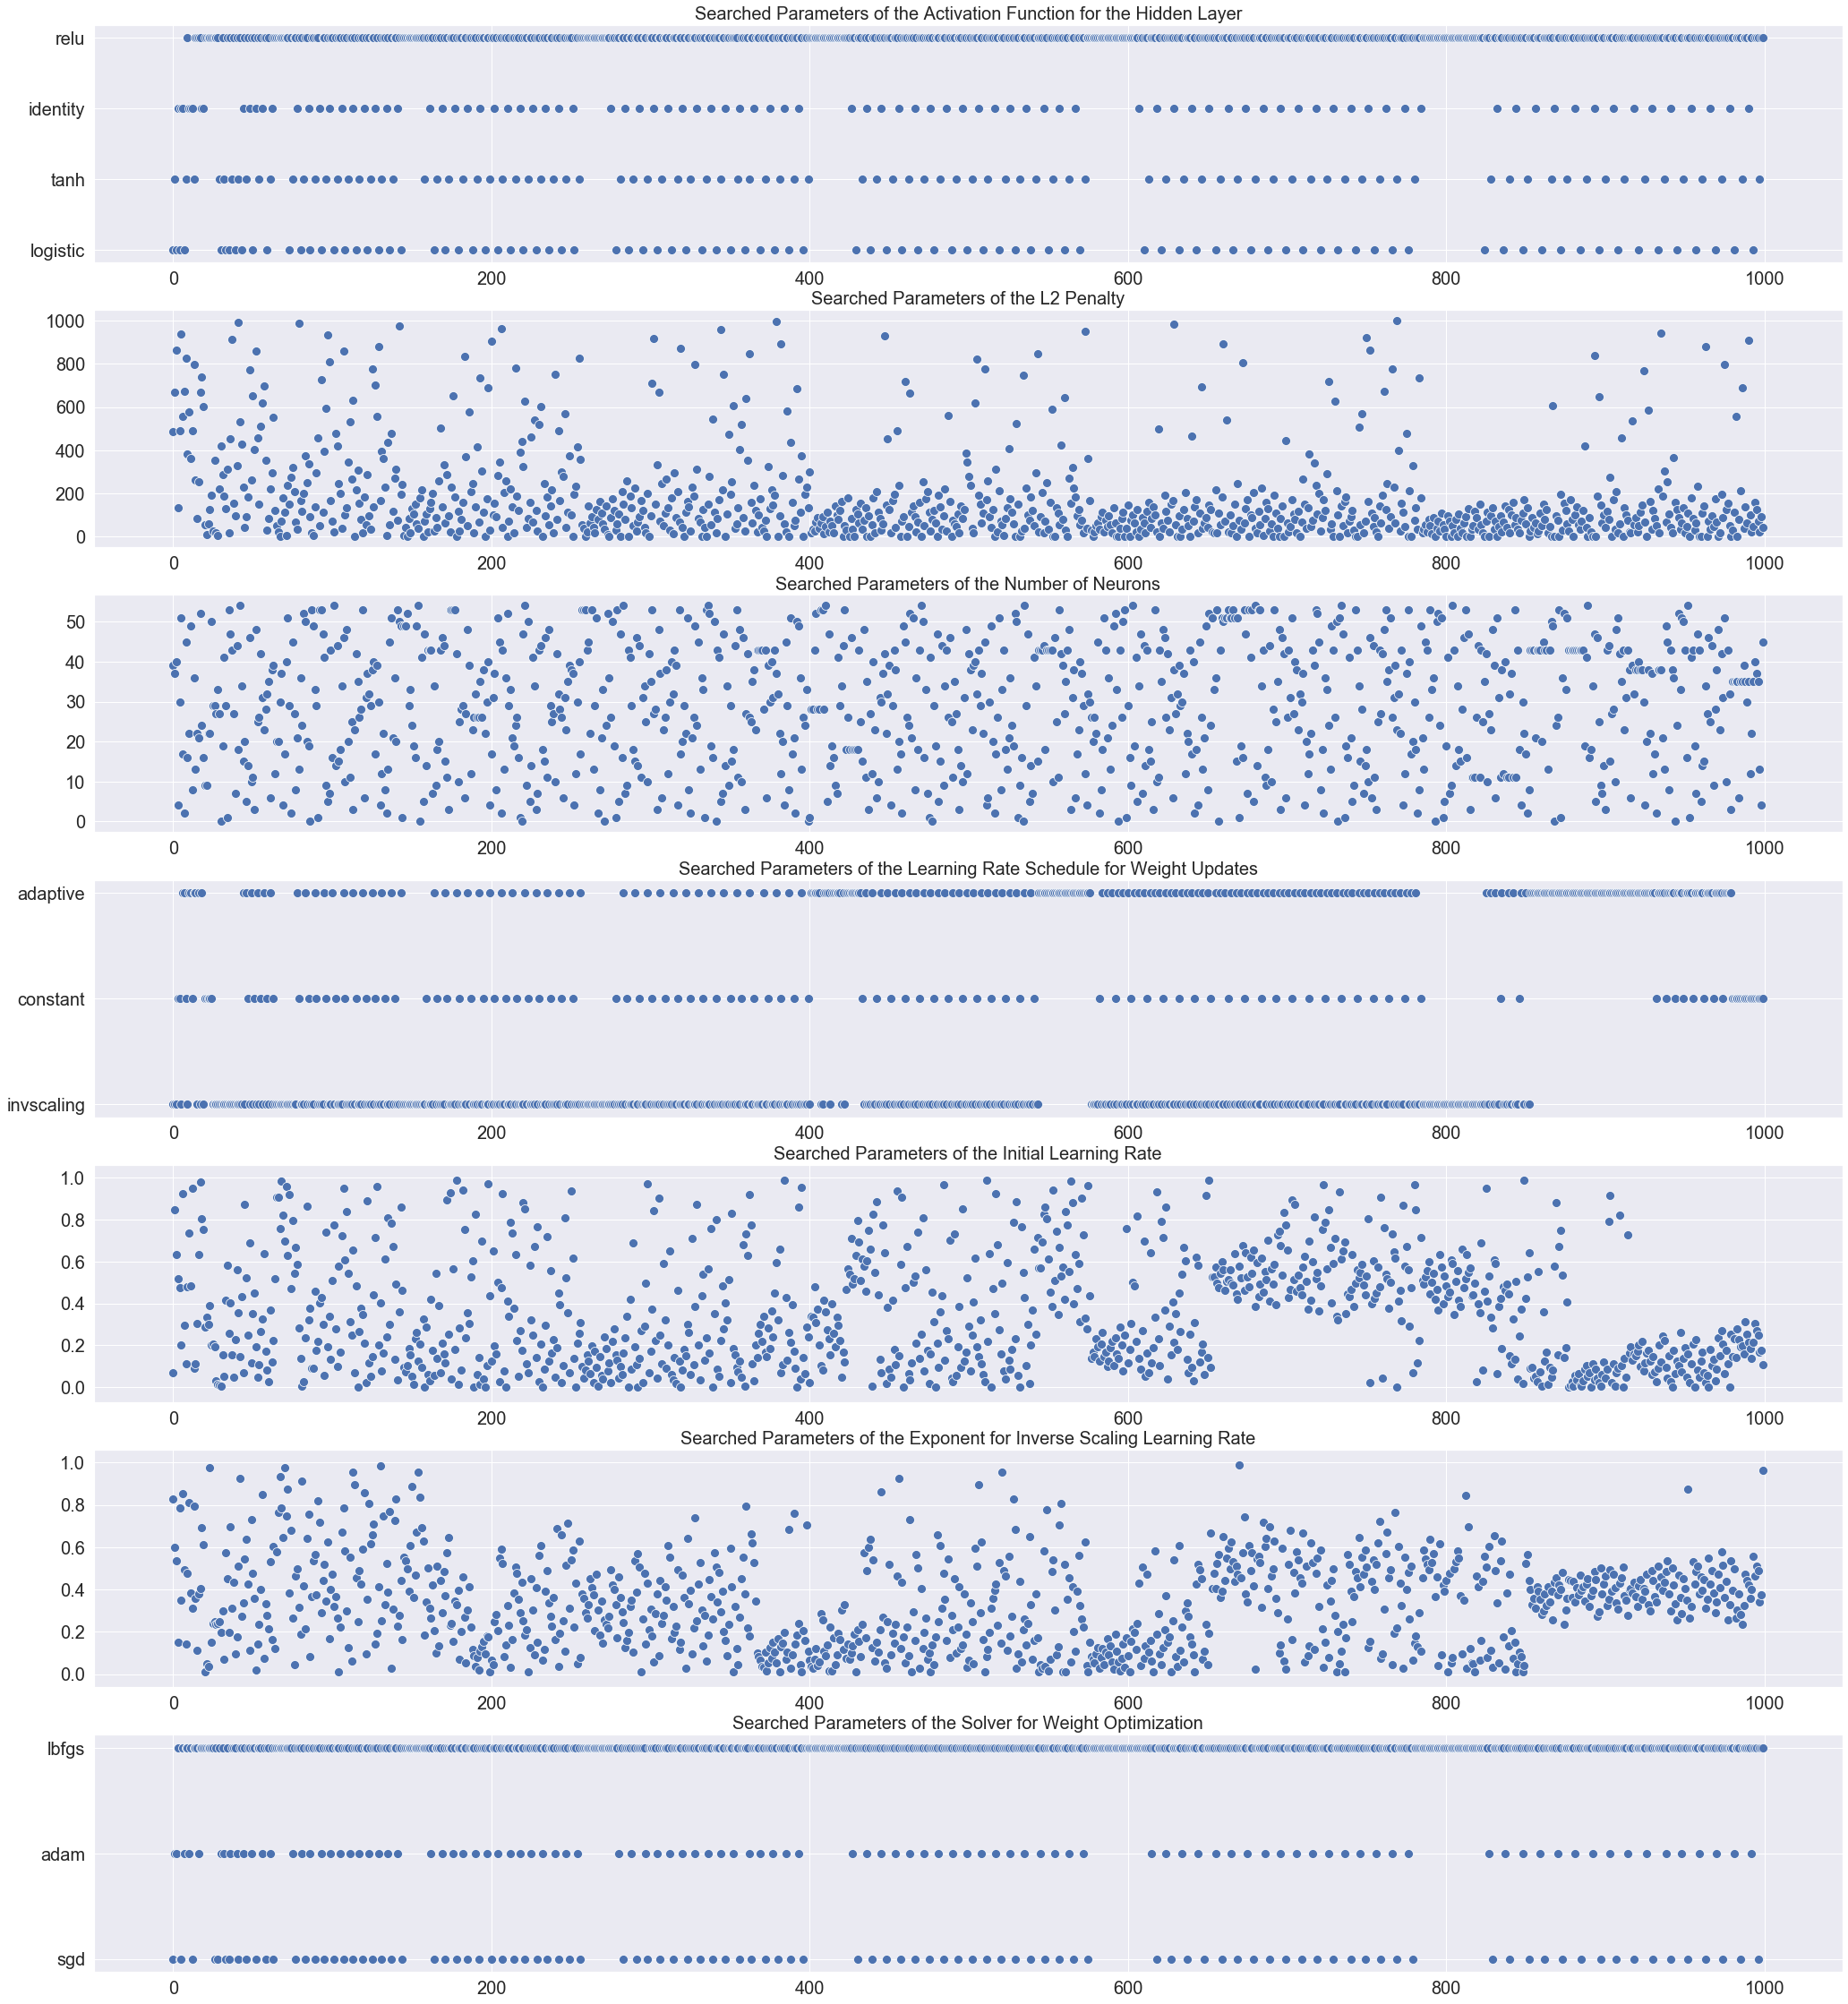

In [16]:
# Set up space dictionary with specified hyperparameters
space = {'hidden_layer_sizes': hp.choice('hidden_layer_sizes', range(1,56)),
         'activation': hp.choice('activation', ['logistic','tanh','relu', 'identity']),
         'solver': hp.choice('solver', ['lbfgs','sgd','adam']),
         'alpha': hp.uniform('alpha', 0.0001, 1000),
         'learning_rate': hp.choice('learning_rate', ['constant', 'invscaling', 'adaptive']),
         'learning_rate_init': hp.uniform('learning_rate_init', 0.001, 0.99),
         'power_t': hp.uniform('power_t', 0.01, 0.99)}

target_clf = [None] * 10
target_clf_fitted = [None] * 10
target_y_pred_proba = [None] * 10
target_y_pred = [None] * 10

# Set up objective function
def objective(params):
    params = {'hidden_layer_sizes': params['hidden_layer_sizes'],
              'activation': params['activation'],
              'solver': params['solver'],
              'alpha': params['alpha'],
              'learning_rate': params['learning_rate'],
              'learning_rate_init': params['learning_rate_init'],
              'power_t': params['power_t']}
        
    hyperopt_clf = MLPClassifier(max_iter=4000,
                                 random_state=42,
                                 warm_start=True,
                                 early_stopping=True,
                                 **params)

    best_score = cross_val_score(estimator=hyperopt_clf,
                                 X=X_train,
                                 y=y_train,
                                 cv=3,
                                 n_jobs=4,
                                 pre_dispatch=10).mean()
    
    loss = 1 - best_score
    return {'best_score': best_score, 'loss': loss, 'status': STATUS_OK,'eval_time': time.time()}

# Run the algorithm
trials = Trials()
best = fmin(fn=objective,
           space=space,
           max_evals=1000,
           rstate=np.random.RandomState(42),
           algo=tpe.suggest,
           trials=trials)
    
best_score = [None] * len(trials.trials)
best_score[0] = trials.results[0].get('best_score')

searched_params_df = pd.DataFrame(trials.trials[0].get('misc').get('vals').values())
searched_params_df = searched_params_df.transpose()

for i in list(range(1, len(trials.trials))):
    new_df = pd.DataFrame(trials.trials[i].get('misc').get('vals').values())
    searched_params_df = searched_params_df.append(new_df.transpose())
    best_score[i] = trials.results[i].get('best_score')

searched_params_df = searched_params_df.rename(columns={0: 'activation', 1: 'alpha', 2: 'hidden_layer_sizes', 
                                                            3: 'learning_rate', 4: 'learning_rate_init', 
                                                            5: 'power_t', 6: 'solver'})
    
blankIndex = [''] * len(searched_params_df)
searched_params_df.index = blankIndex
    
i = ['activation', 'learning_rate', 'solver']
j = ['logistic', 'constant', 'lbfgs']
k = ['tanh', 'invscaling', 'sgd']
l = ['relu', 'adaptive', 'adam']
m = ['identity']

for (i, j, k, l) in zip(i, j, k, l):
    searched_params_df[i] = searched_params_df[i].replace({0: j, 1: k, 2: l, 3: m})

searched_params_df['best_score'] = best_score

searched_params_df_sorted = searched_params_df.sort_values(by='best_score', 
                                                               axis=0, 
                                                               ascending=False)
    
searched_params_df_sorted = searched_params_df_sorted[searched_params_df_sorted.hidden_layer_sizes != 0]

print(searched_params_df_sorted.head(5).transpose())
    
# Learn to predict each class against the other
        
for i in range(5):
    target_clf[i] = MLPClassifier(max_iter=4000,
                                            random_state=42,
                                            warm_start=True,
                                            early_stopping=True,
                                            activation=searched_params_df_sorted.values[i][0],
                                            alpha=searched_params_df_sorted.values[i][1],
                                            hidden_layer_sizes=int(searched_params_df_sorted.values[i][2]),
                                            learning_rate=searched_params_df_sorted.values[i][3],
                                            learning_rate_init=searched_params_df_sorted.values[i][4],
                                            power_t=searched_params_df_sorted.values[i][5],
                                            solver=searched_params_df_sorted.values[i][6])
    

for i in range(5):
    target_clf_fitted[i] = target_clf[i].fit(X_train, y_train)
    target_y_pred_proba[i] = target_clf[i].predict_proba(X_test)
    target_y_pred[i] = target_clf[i].predict(X_test)

# Create the parameter grid
param_grid = {'hidden_layer_sizes': list(product(range(1,56), range(1,56)))}
    
# Create a random search object
ran_clf = RandomizedSearchCV(estimator = MLPClassifier(max_iter=4000,
                                                           random_state=42,
                                                           warm_start=True,
                                                           early_stopping=True,
                                                           activation=searched_params_df_sorted.values[0][0],
                                                           alpha=searched_params_df_sorted.values[0][1],
                                                           learning_rate=searched_params_df_sorted.values[0][3],
                                                           learning_rate_init=searched_params_df_sorted.values[0][4],
                                                           power_t=searched_params_df_sorted.values[0][5],
                                                           solver=searched_params_df_sorted.values[0][6]),
                                 param_distributions=param_grid,
                                 n_iter=465,
                                 n_jobs=4,
                                 pre_dispatch=100,
                                 cv=3,
                                 random_state=42)

ran_clf_fitted = ran_clf.fit(X_train, y_train)

#Configuration of Layer 1 & 2
mean_test_score = list(ran_clf_fitted.cv_results_.get('mean_test_score'))
hidden_layers = list(ran_clf_fitted.cv_results_.get('param_hidden_layer_sizes'))

best_hidden_layers_df = pd.DataFrame({'Hidden Layers': hidden_layers, 'Mean Test Score': mean_test_score})

blankIndex = [''] * len(best_hidden_layers_df)
best_hidden_layers_df.index = blankIndex

# Print out the best configuration of hidden layers
best_hidden_layers_df_sorted = best_hidden_layers_df.sort_values(by='Mean Test Score', 
                                                                     axis=0, 
                                                                     ascending=False)

print(best_hidden_layers_df_sorted.head(5).transpose())

for i in range(5, 10):
      target_clf[i] = MLPClassifier(max_iter=4000,
                                            random_state=42,
                                            warm_start=True,
                                            early_stopping=True,
                                            activation=searched_params_df_sorted.values[0][0],
                                            alpha=searched_params_df_sorted.values[0][1],
                                            hidden_layer_sizes=best_hidden_layers_df_sorted['Hidden Layers'].values[i-6],
                                            learning_rate=searched_params_df_sorted.values[0][3],
                                            learning_rate_init=searched_params_df_sorted.values[0][4],
                                            power_t=searched_params_df_sorted.values[0][5],
                                            solver=searched_params_df_sorted.values[0][6])
    
for i in range(5, 10):
    target_clf_fitted[i] = target_clf[i].fit(X_train, y_train)
    target_y_pred_proba[i] = target_clf[i].predict_proba(X_test)
    target_y_pred[i] = target_clf[i].predict(X_test)

sns.set(rc={'figure.figsize': (35,40), 'legend.fontsize': 25, 'xtick.labelsize': 20, 'ytick.labelsize': 20, 
                'lines.markersize': 10, 'axes.labelsize': 0, 'axes.titlesize': 20})

fig, ax = plt.subplots(7,1)

j = ['Activation Function for the Hidden Layer', 'L2 Penalty', 'Number of Neurons', 
         'Learning Rate Schedule for Weight Updates', 'Initial Learning Rate', 'Exponent for Inverse Scaling Learning Rate',
         'Solver for Weight Optimization']
k = ['activation', 'alpha', 'hidden_layer_sizes', 'learning_rate', 'learning_rate_init', 'power_t', 'solver']
    
for (i, j, k) in zip(range(7), j, k):
    
    ax[i].set_title('Searched Parameters of the {}'.format(j))
    sns.scatterplot(x=list(range(0, len(trials.trials))), 
                        y=searched_params_df[k].values, 
                        ax=ax[i])

In [17]:
# Print classification report

i = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
j = ['1stBest_1Layer', '2ndBest_1Layer', '3rdBest_1Layer', '4thBest_1Layer', '5thBest_1Layer', 
     '1stBest_2Layers', '2ndBest_2Layers', '3rdBest_2Layers', '4thBest_2Layers', '5thBest_2Layers']

for (i, j) in zip(i, j):
    print('{}----------'.format(j))
    print()
    print(multilabel_confusion_matrix(y_true=y_test, 
                                      y_pred=target_y_pred[i]))
    print(classification_report(y_true=y_test, 
                                y_pred=target_y_pred[i],
                                digits=2))

1stBest_1Layer----------

[[[  80   34]
  [  24 1050]]

 [[1069   29]
  [  51   39]]

 [[1163    4]
  [  21    0]]

 [[1183    2]
  [   2    1]]]
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1074
           1       0.57      0.43      0.49        90
           2       0.00      0.00      0.00        21
           3       0.33      0.33      0.33         3

   micro avg       0.94      0.92      0.93      1188
   macro avg       0.47      0.44      0.45      1188
weighted avg       0.92      0.92      0.92      1188
 samples avg       0.92      0.92      0.92      1188

2ndBest_1Layer----------

[[[  77   37]
  [  25 1049]]

 [[1073   25]
  [  52   38]]

 [[1166    1]
  [  21    0]]

 [[1184    1]
  [   2    1]]]
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1074
           1       0.60      0.42      0.50        90
           2       0.00      0.00      0.00        21
  

In [18]:
# Computing feature importance
print('Best MLP estimator: {}'.format(target_clf[0]))
print()
print('Best results')
print(multilabel_confusion_matrix(y_true=y_test, 
                                  y_pred=target_y_pred[0]))
print(classification_report(y_true=y_test, 
                            y_pred=target_y_pred[0],
                            digits=2))

perm = PermutationImportance(estimator=target_clf[0],
                             n_iter=100,
                             random_state=42).fit(X_test, y_test)

# Create a dataframe of the variables and feature importances
feature_importances_df = pd.DataFrame({'Variable': X.columns, 'Feature_Importances': perm.feature_importances_})

# Print out the top 3 positive variables
feature_importances_df_sorted = feature_importances_df.sort_values(by='Feature_Importances', 
                                                                   axis=0, 
                                                                   ascending=False)
print()
print(feature_importances_df_sorted)

Best MLP estimator: MLPClassifier(activation='relu', alpha=21.634787039154073, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=38, learning_rate='adaptive',
              learning_rate_init=0.16146925676060042, max_iter=4000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.399917755259629, random_state=42, shuffle=True,
              solver='lbfgs', tol=0.0001, validation_fraction=0.1,
              verbose=False, warm_start=True)

Best results
[[[  80   34]
  [  24 1050]]

 [[1069   29]
  [  51   39]]

 [[1163    4]
  [  21    0]]

 [[1183    2]
  [   2    1]]]
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      1074
           1       0.57      0.43      0.49        90
           2       0.00      0.00      0.00        21
           3       0.33      0.33      0.33         3

   micro avg       0.94      